# dropkick

---

#### Automated cell filtering for scRNA-seq data.  
#### The following tutorial will walk through the `dropkick` pipeline, parameters, and outputs.

In [1]:
import scanpy as sc; sc.set_figure_params(color_map="viridis", frameon=False)
import dropkick as dk

### 1. Read in counts data
`dropkick` works primarily with [**Scanpy**](https://icb-scanpy.readthedocs-hosted.com/en/stable/)'s `AnnData` objects, and accepts input files in `.h5ad` or flat (`.csv`, `.tsv`) format. It also writes outputs to `.h5ad` files when called from the command line.

We can read in an example PBMC dataset generated using [**10X Chromium**](https://support.10xgenomics.com/single-cell-gene-expression/datasets) single-cell RNA sequencing.

In [2]:
adata = sc.read("data/pbmc_4k.h5ad")

---
### 1.5. Plot QC metrics (optional)
The `qc` module has functions for plotting total UMI distribution and ambient genes, to give an idea of overall data quality and amenability to `dropkick` filtering. 

In [3]:
# simple preprocessing of anndata object to get metrics for plot
adata = dk.recipe_dropkick(adata, n_hvgs=None, X_final="raw_counts")

Ignoring 729002 barcodes with less than 50 genes detected
Ignoring 13812 genes with zero total counts
Top 10 ambient genes have dropout rates between 7.127 and 25.368 percent:
	['MALAT1', 'B2M', 'TMSB4X', 'EEF1A1', 'RPL21', 'RPL13', 'RPS27', 'RPL13A', 'RPLP1', 'RPS3A']


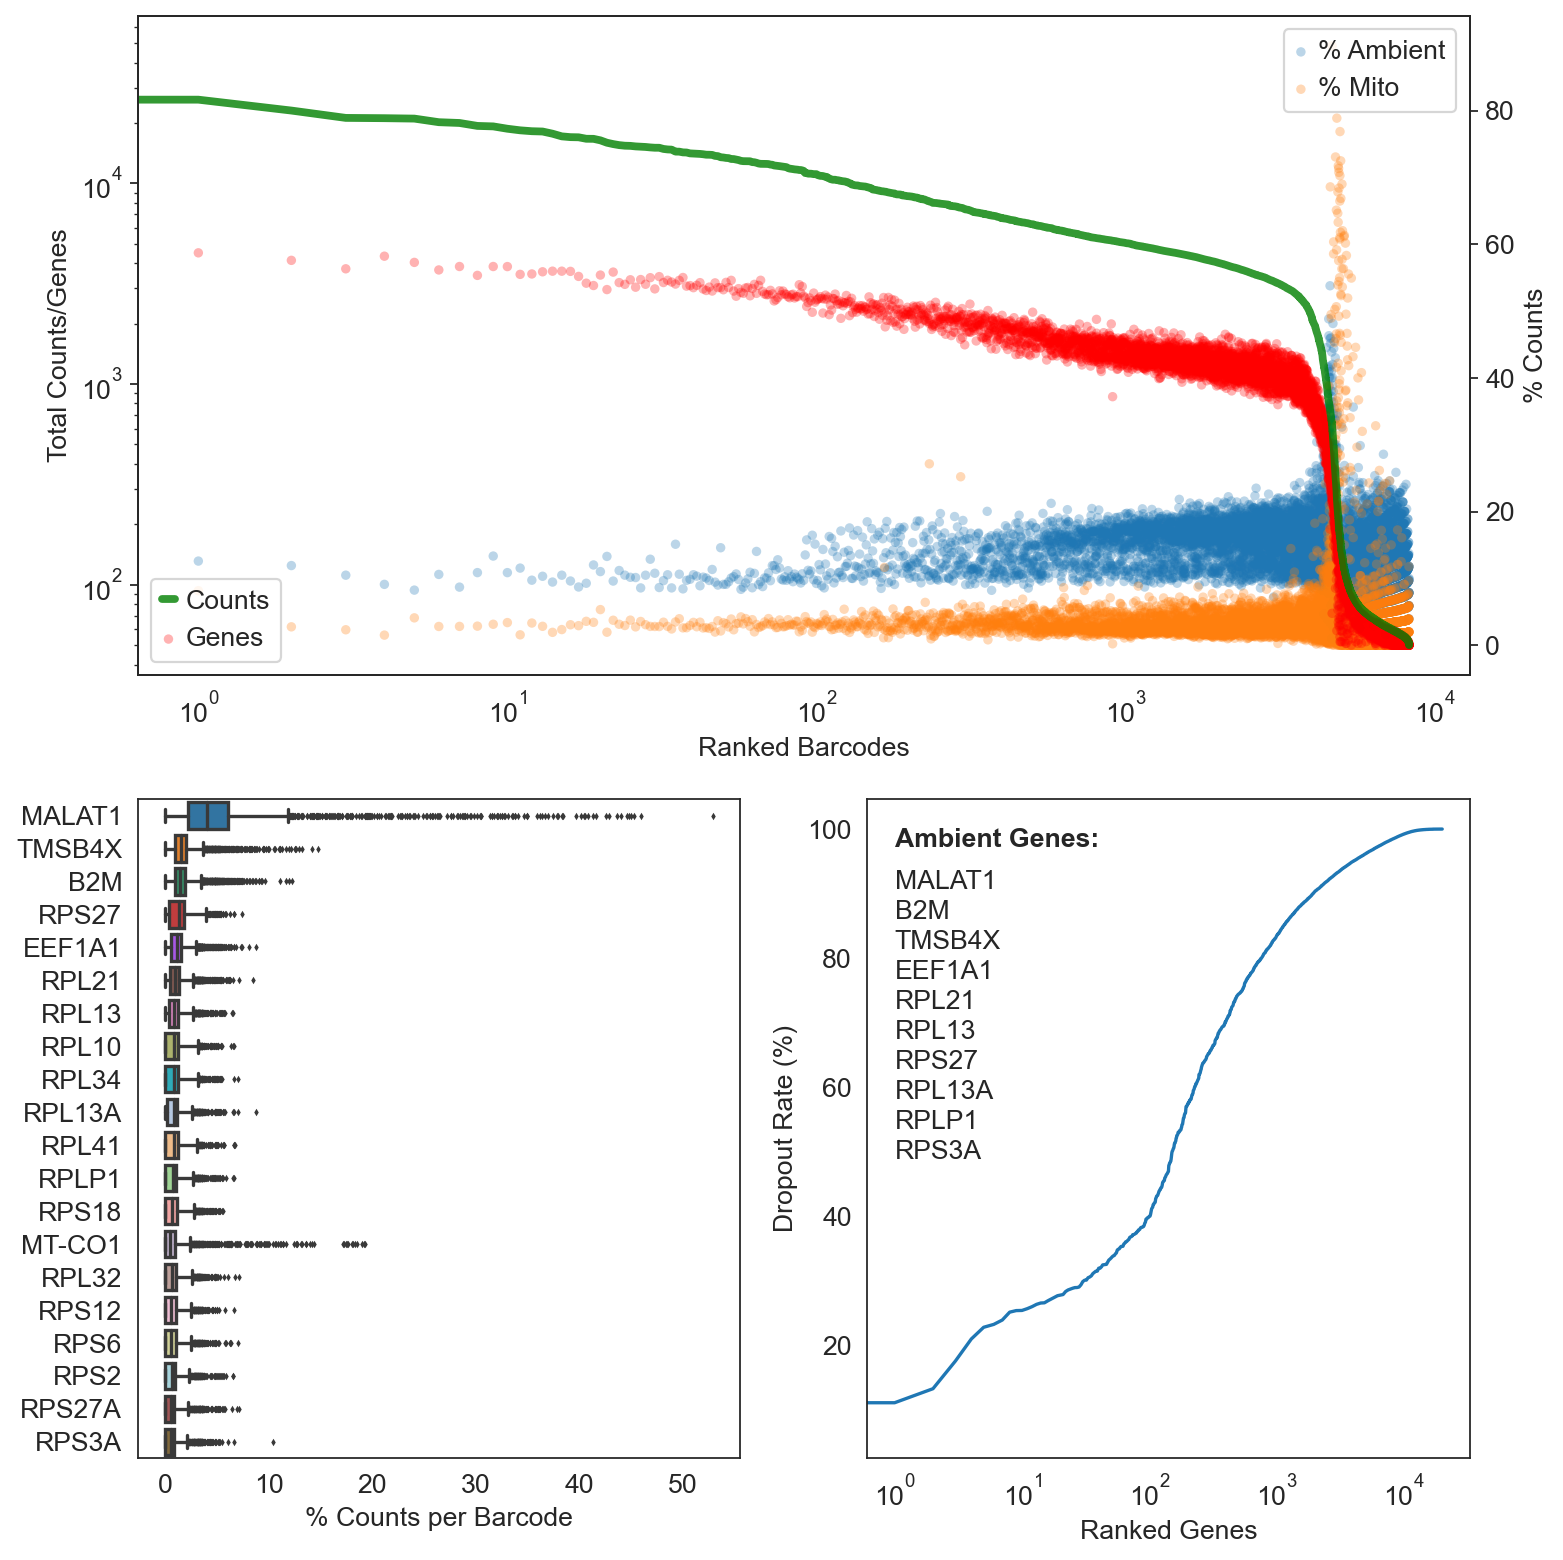

In [4]:
qc_plt = dk.qc_summary(adata)

We can see from the total counts profile (top) that this sample has relatively low background ("empty" droplets), as indicated by the steep dropoff in counts and genes around barcode 5,000.

The dropout rate distribution also looks pretty good, with a steep increase in dropout rate following the first few highly-expressed genes (_MALAT1_, _RPS27_, _B2M_).

---
### 2. Run `dropkick` pipeline function
This tool preprocesses the data to automatically calculate thresholds on global metrics, then trains a [glmnet](https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html)-style logistic regression model to determine scores and labels for each barcode in the dataset describing likelihood of being a real cell (rather than empty droplet).

The `n_jobs` parameter will parallelize the model training. Since the default is 5-fold cross-validation, we'll use 5 cores to quickly train **dropkick**.

In [5]:
%time adata_rc = dk.dropkick(adata, n_jobs=5)

Top 10 ambient genes have dropout rates between 7.127 and 25.368 percent:
	['MALAT1', 'B2M', 'TMSB4X', 'EEF1A1', 'RPL21', 'RPL13', 'RPS27', 'RPL13A', 'RPLP1', 'RPS3A']
Determining 2000 highly variable genes
Setting arcsinh_norm layer to .X
Thresholding on heuristics for training labels:
	['arcsinh_n_genes_by_counts']
Ignoring 3421 barcodes below first threshold on arcsinh_n_genes_by_counts
Training dropkick with alphas:
	[0.1]


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   19.9s remaining:   29.9s


Chosen lambda value:
	[0.09398878]
Assigning scores and labels
Done!

CPU times: user 1min 50s, sys: 5.49 s, total: 1min 55s
Wall time: 46.2 s


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   20.3s finished


---
### 3. Explore output
Running **dropkick** interactively adds the following attributes to the input `AnnData` object:
* `.obs['dropkick_score']`
    * Probability of being a real cell
    * Values closer to 0 indicate empty droplets with high ambient RNA content
* `.obs['dropkick_label']`
    * Binary label generated by using cutoff of 0.5 on `'dropkick_score'`
    * Dropkick's best estimate of a "good" dataset
    * User is encouraged to adjust the cutoff according to whether they are more concerned with *false negatives* or *false positives*
* `.obs[<metrics>]`
    * Metrics used for thresholding (`metrics` parameter, default `['arcsinh_n_genes_by_counts']`, are kept
* `.var['dropkick_coef']`
    * Logistic regression coefficient values for each highly variable gene (HVG) determined by the **dropkick** pipeline
* `.uns['dropkick_thresholds']`
    * Dictionary of global metrics thresholded by **dropkick** with the resulting threshold values and directions for good training cells
* `.uns['dropkick_args']`
    * Dictionary of all arguments used to run the pipeline

In [6]:
adata

AnnData object with n_obs × n_vars = 8278 × 19882 
    obs: 'CellRanger_2', 'CellRanger_3', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ambient', 'arcsinh_total_counts', 'arcsinh_n_genes_by_counts', 'dropkick_score', 'dropkick_label'
    var: 'gene_ids', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'total_counts', 'dropkick_coef'
    uns: 'dropkick_thresholds', 'dropkick_args'
    layers: 'raw_counts', 'arcsinh_norm'

We can look at the distribution of **dropkick** scores for all barcodes with greater than 50 total genes detected (well below average for real cells; removes noise from hundreds of thousands of junk barcodes kept by the 10X CellRanger pipeline).

The `score_plot` function displays these barcodes in a scatter plot of **ambient percentage** (as calculated in the `qc_summary` plot above) versus **total genes** detected for each cell. The automated thresholds on the latter heuristic are overlayed to show the initial training labels given to the **dropkick** model.

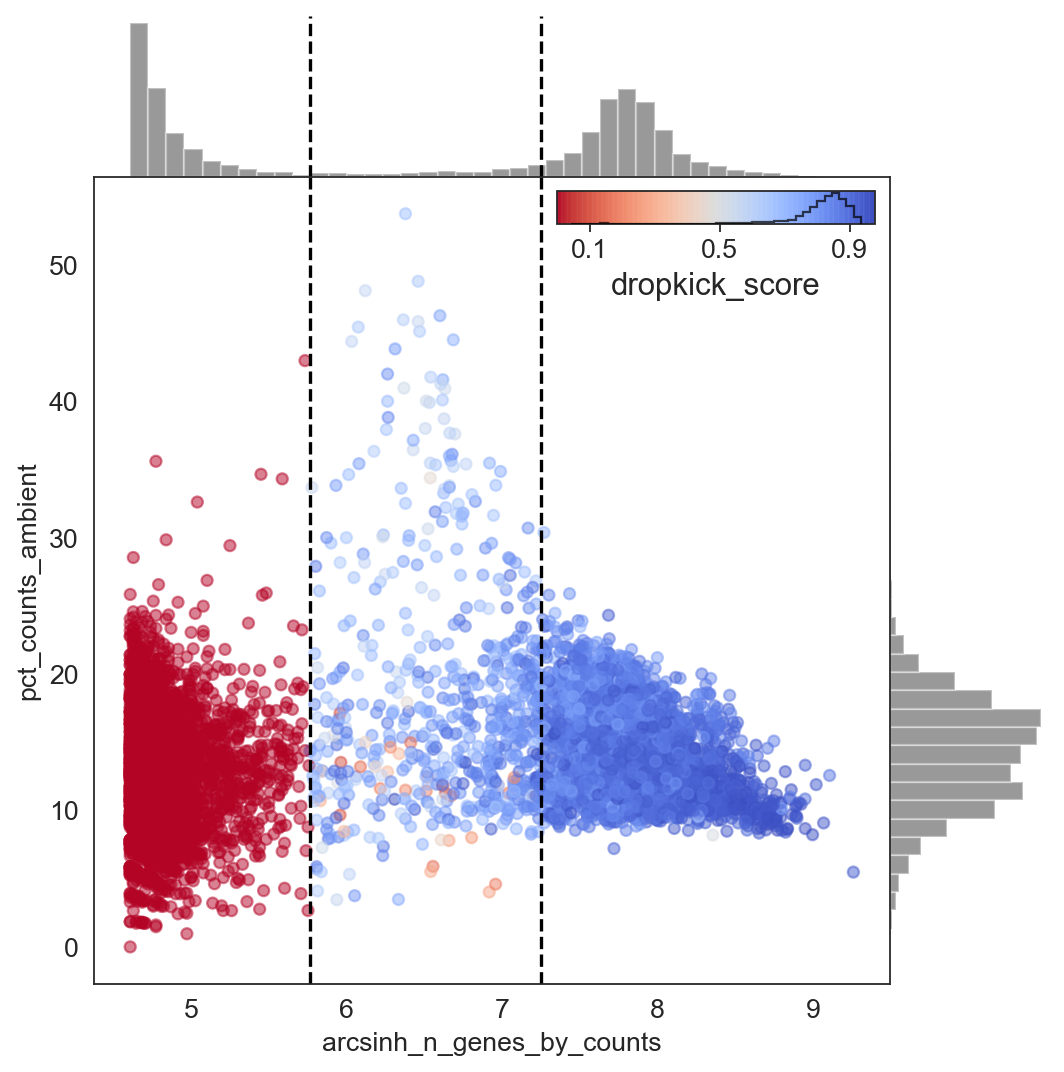

In [7]:
score_plt = dk.score_plot(adata)

We can list the top **dropkick** gene coefficients for both good cells (highly positive) and putative empty droplets (highly negative) with `coef_inventory`.

In [8]:
dk.coef_inventory(adata)


Top HVGs by coefficient value (good cells):
index
UBC         0.184770
CD69        0.121836
MYL6        0.117864
CCT8        0.102479
ALDOA       0.093636
HLA-DPA1    0.092660
WDR83OS     0.086655
HLA-DQA1    0.077780
RBX1        0.072039
RPL22L1     0.071927
Name: dropkick_coef, dtype: float64

Bottom HVGs by coefficient value (bad droplets):
index
TUBB1         -0.052091
MT-CO2        -0.043881
PF4           -0.043691
HIST1H2AC     -0.041793
S100A8        -0.040932
TMEM147-AS1   -0.038858
GNG11         -0.037194
PPBP          -0.029504
OCLN          -0.028693
NRGN          -0.027515
Name: dropkick_coef, dtype: float64

1796 coefficients equal to zero. Model sparsity: 89.8 %



The `coef_plot` function will plot these **coefficient values** and **cross validation (CV) scores** for the tested regularization values of **lambda**. Top and bottom three genes by coefficient are notated for reference.

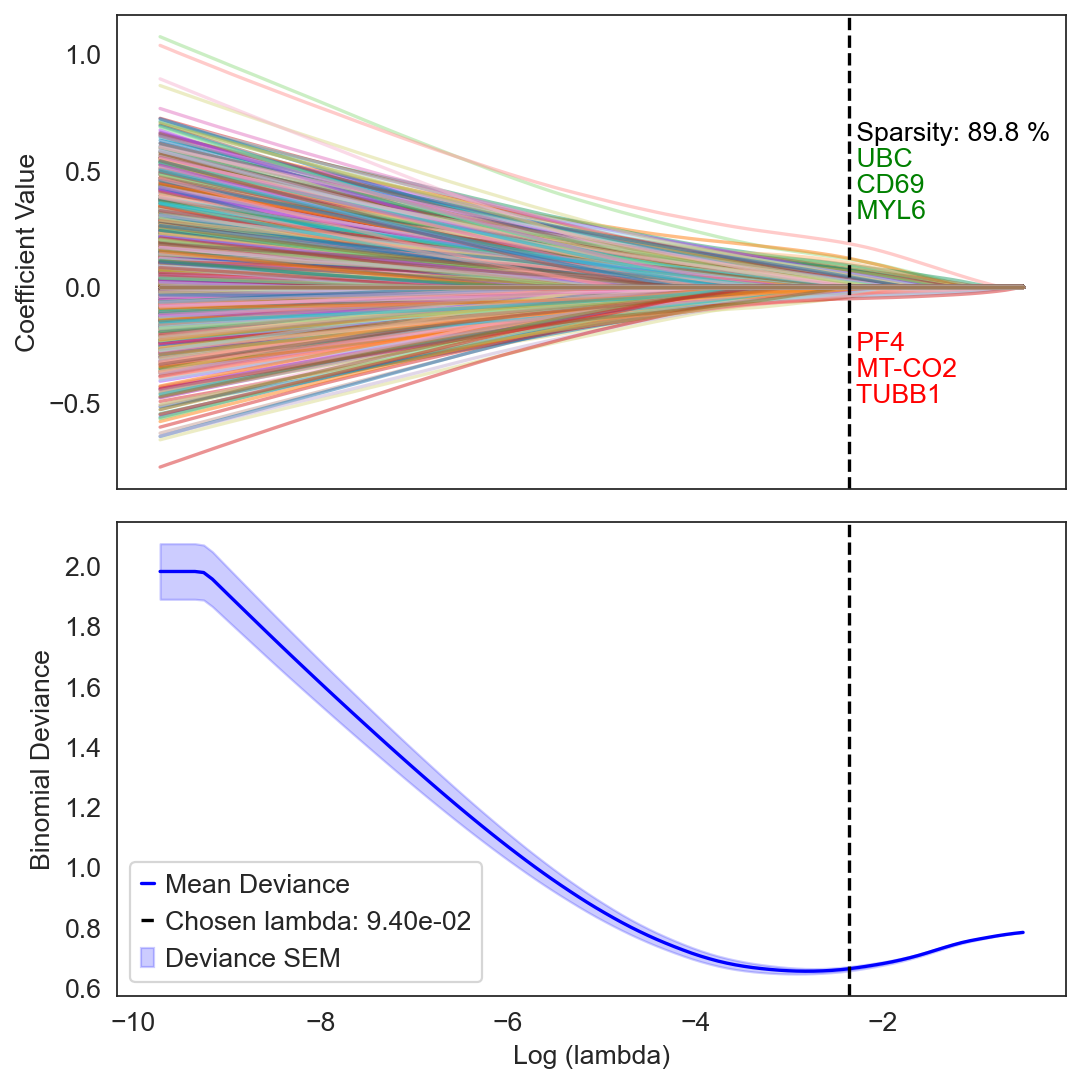

In [9]:
coef_plt = dk.coef_plot(adata)

---
#### Now, let's take the putative real cells using **dropkick**, **CellRanger 2**, and **CellRanger 3** ([**EmptyDrops**](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1662-y)) labels and visualize our resulting, filtered dataset.

In [10]:
# make a copy of our AnnData object, keeping all barcodes kept by dropkick, CellRanger, or EmptyDrops
adata_filtered = adata[
    (adata.obs.dropkick_label==1) | (adata.obs.CellRanger_2==1) | (adata.obs.CellRanger_3==1),
    :].copy()
adata_filtered.shape

(4910, 19882)

For simplicity, **dropkick** has a "recipe" function that will perform preprocessing and normalization for us to prepare for dimension reduction, clustering, and embedding.

In [11]:
# here, we want to end up working with normalized, arcsinh-transformed counts 
#   where genes are scaled to unit variance and zero-centered
# we also set filter=True to remove any genes with zero total counts
# we perform a variable gene selection for 2000 HVGs before further processing
adata_filtered = dk.recipe_dropkick(adata_filtered, X_final="arcsinh_norm", filter=True, n_hvgs=2000, verbose=True)

Ignoring 20 genes with zero total counts
Top 10 ambient genes have dropout rates between 0.305 and 1.955 percent:
	['B2M', 'MALAT1', 'TMSB4X', 'MT-CO2', 'MT-CO1', 'EEF1A1', 'ACTB', 'MT-CO3', 'RPL13', 'HLA-B']
Determining 2000 highly variable genes
Setting arcsinh_norm layer to .X


Let's calculate cell cycle scores for plotting on our dimension-reduced projections. Here we use a list of human cell cycle genes defined in [Tirosh, et al. 2015](https://doi.org/10.1126/science.aad0501).

In [12]:
cc_genes = [x.strip() for x in open('data/cell_cycle_genes.txt')]
s_genes = cc_genes[:43]  # first 43 genes are s-phase
g2m_genes = cc_genes[43:]
# score cell cycle using scanpy function
sc.tl.score_genes_cell_cycle(adata_filtered, s_genes=s_genes, g2m_genes=g2m_genes)

Next we can run **PCA** as an initial dimension reduction, followed by **UMAP** to embed the cells in a 2-dimensional space.

... storing 'phase' as categorical


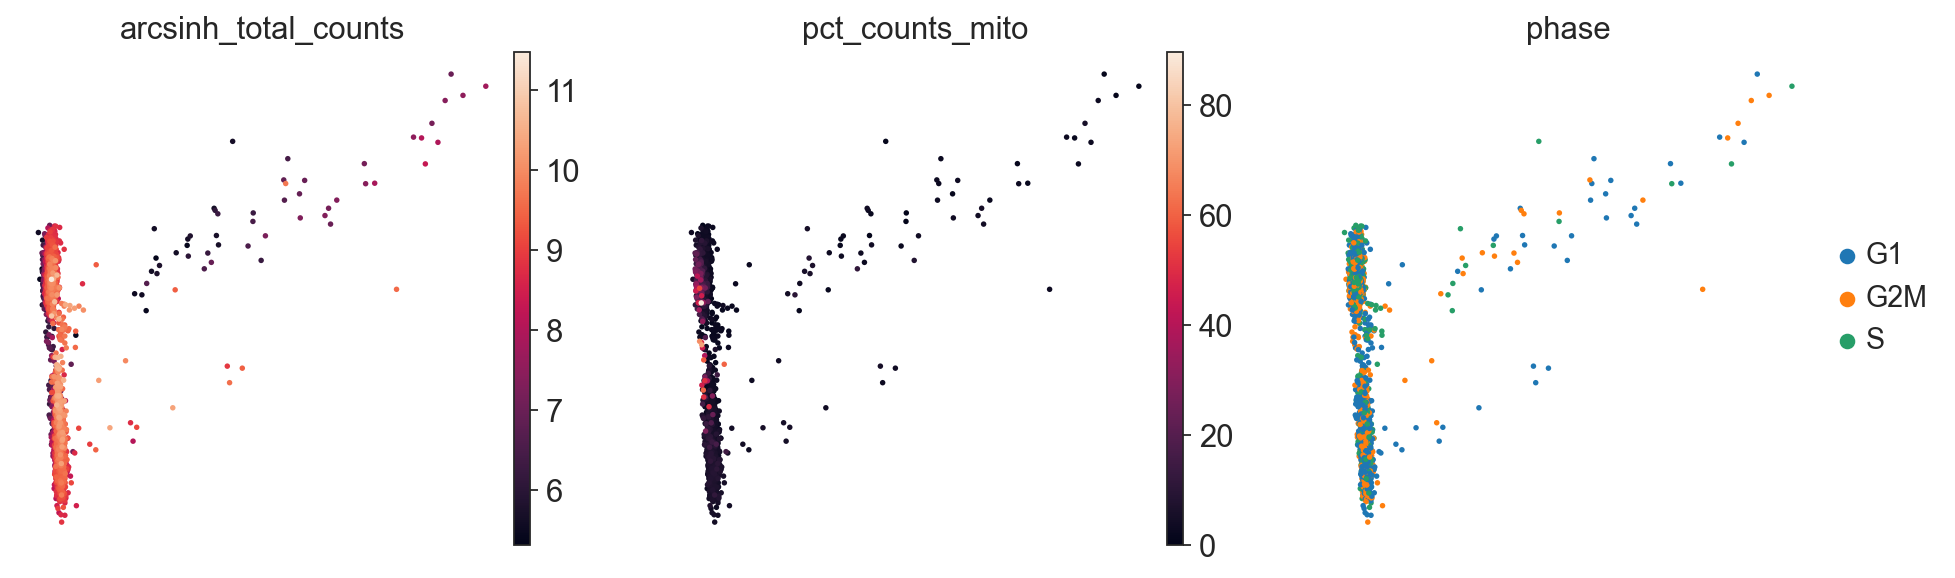

/Users/cody/.virtualenvs/dropkick/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/cody/.virtualenvs/dropkick/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


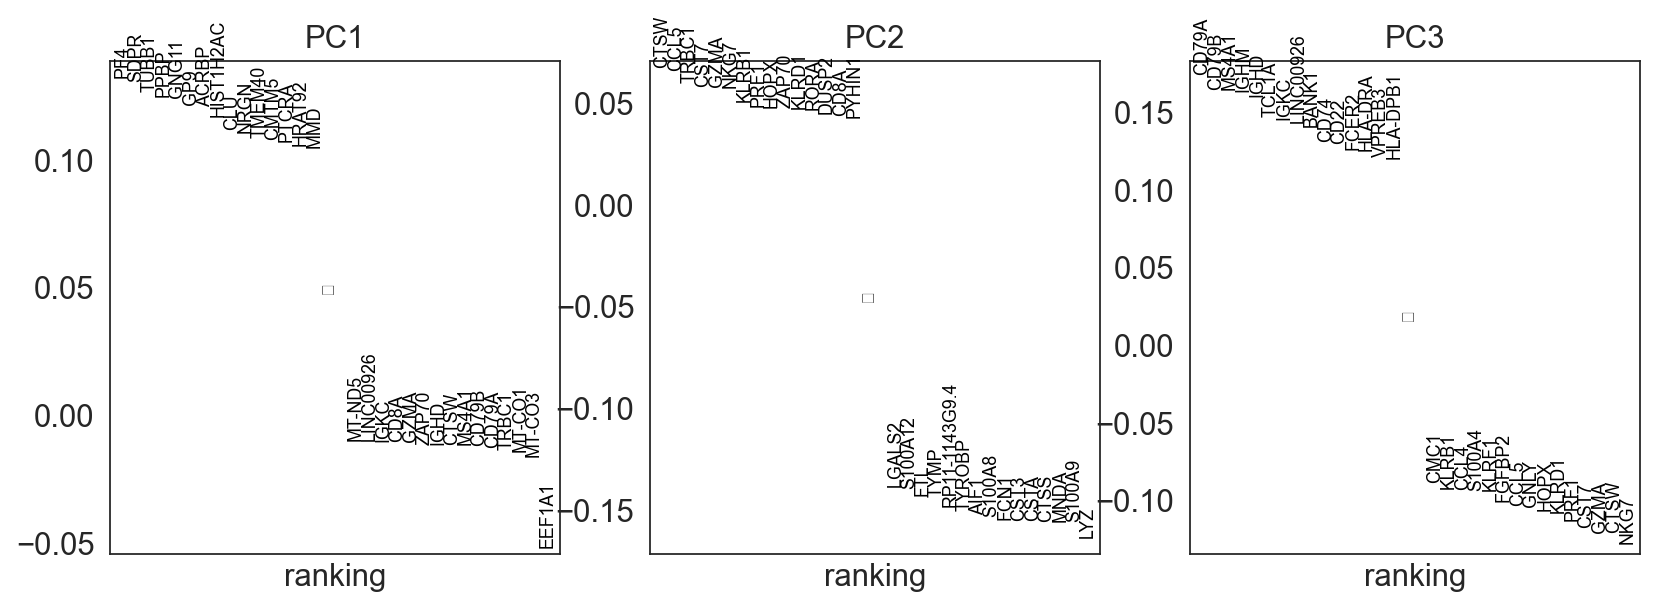

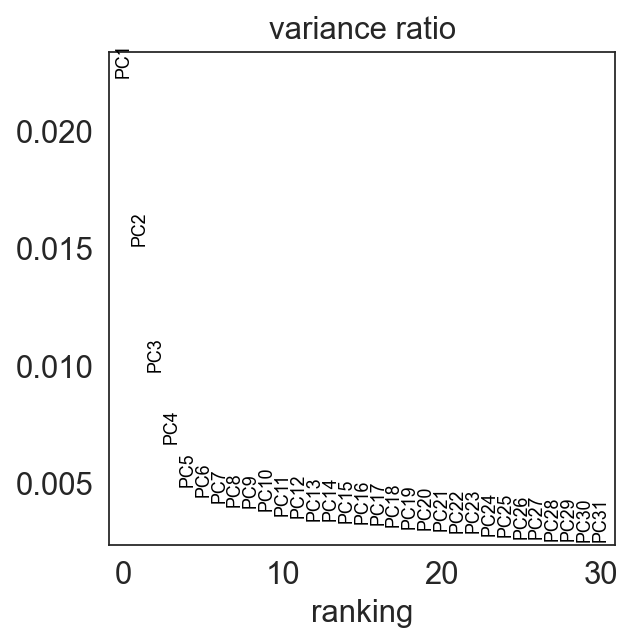

In [13]:
sc.tl.pca(adata_filtered, n_comps=50, use_highly_variable=True)
sc.pl.pca_overview(adata_filtered, color=["arcsinh_total_counts","pct_counts_mito","phase"])

Using the first few PCs, construct a neighbor graph that can be clustered with the **Leiden** algorithm, then embed the dataset using **UMAP** and visualize resulting clusters.

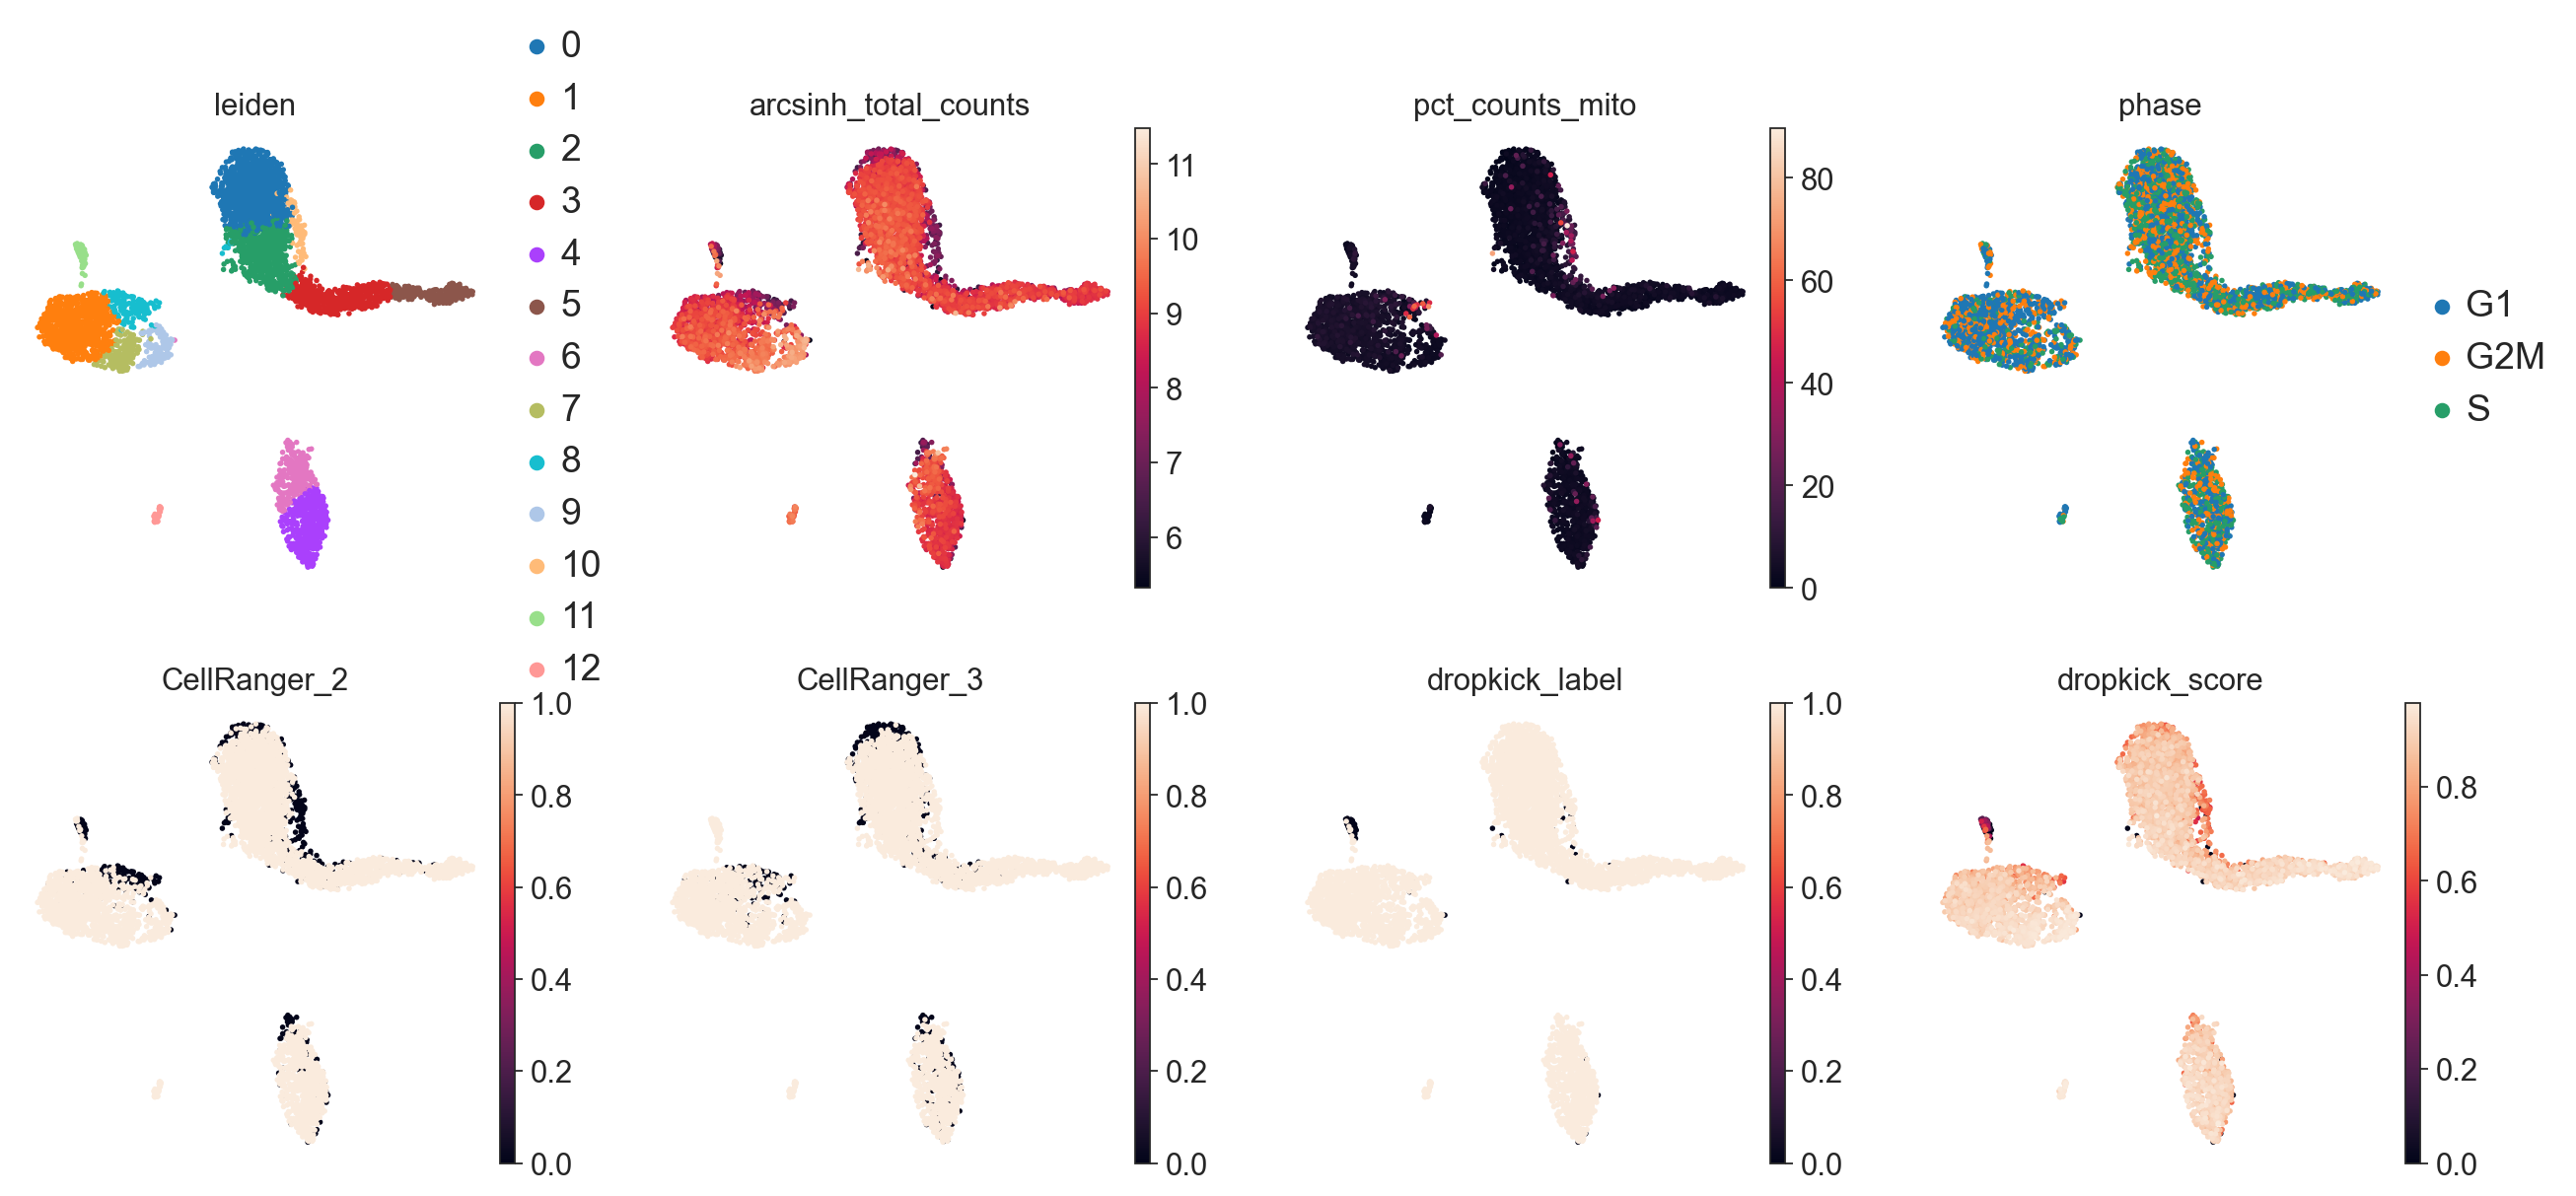

In [14]:
sc.pp.neighbors(adata_filtered, n_neighbors=30, random_state=1, n_pcs=10)
sc.tl.leiden(adata_filtered)
sc.tl.umap(adata_filtered, random_state=1)
# plot results
sc.pl.umap(
    adata_filtered,
    color=[
        "leiden",
        "arcsinh_total_counts",
        "pct_counts_mito",
        "phase",
        "CellRanger_2",
        "CellRanger_3",
        "dropkick_label",
        "dropkick_score",
    ],
    legend_fontsize="large",
    ncols=4,
)